# Part 1: Network Training

## Step0: Import Package & Hyperparameter Configuration

In [103]:
"""
2025/02/03: 1.新增normDict計算 #!注意normDict是有先經過資料前處理計算的
            2.資料集中任意取n筆去訓練(n:自填數) 
            
2025/03/17: 1.修改增加Hdc,N輸入參數
            2.Mdoel修正兩個子迴路接考慮Hdc與N            
            
"""

'\n2025/02/03: 1.新增normDict計算 #!注意normDict是有先經過資料前處理計算的\n            2.資料集中任意取n筆去訓練(n:自填數) \n            \n2025/03/17: 1.修改增加Hdc,N輸入參數\n            2.Mdoel修正兩個子迴路接考慮Hdc與N            \n            \n'

In [104]:
%reset -f  # 清空所有變數

import gc
gc.collect()  # 強制 Python 回收記憶體


Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  清空所有變數, please run `%reset?` for details


0


### Package


In [105]:
import os
import torch
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

### Hyperparameter Config

In [106]:
# %%
# Unified Hyperparameter Configuration
class Config:
    SEED = 1
    NUM_EPOCHS = 3000
    BATCH_SIZE = 128
    LEARNING_RATE = 0.002  #論文提供
    LR_SCHEDULER_GAMMA = 0.99  #論文提供
    DECAY_EPOCH = 200
    DECAY_RATIO = 0.5
    EARLY_STOPPING_PATIENCE = 500
    HIDDEN_SIZE = 30
    OPERATOR_SIZE = 30


# Reproducibility
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Material & Number of Data

In [107]:
material = "CH467160"
down_sample_way = "range"
downsample = 128

# 訓練情況況
plot_interval = 300
train_show_sample = 1

# 定義保存模型的路徑
model_save_dir = f"./Model/{down_sample_way}/{downsample}/"
os.makedirs(model_save_dir, exist_ok=True)  # 如果路徑不存在，創建路徑
model_save_path = os.path.join(model_save_dir, f"{material}.pt")  # 定義模型保存檔名

figure_save_base_path = f"./figure/{down_sample_way}/{downsample}/"
os.makedirs(figure_save_base_path, exist_ok=True)  # 如果路徑不存在，創建路徑

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step1: Data processing and data loader generate 

In [ ]:
# %% Preprocess data into a data loader
def get_dataloader(data_B,
                   data_F,
                   data_T,
                   data_H,
                   data_N,
                   data_Hdc,
                   data_Pcv,
                   n_init=16):
    """ #*(Date:250105)
    Process data and return DataLoader for training, validation, and testing.

    Parameters
    ----------
    data_B : np.array
        Magnetic flux density data.
    data_F : np.array
        Frequency data.
    data_T : np.array
        Temperature data.
    data_N : np.array
        Turns data.
    data_Hdc : np.array
        DC Magnetic field strength data.
    data_H : np.array
        AC Magnetic field strength data.
    data_Pcv : np.array
        Core loss data.
    norm : list
        Normalization parameters for the features.
    n_init : int
        Number of initial data points for magnetization.

    Returns
    -------
        train_loader, valid_loader : DataLoader
        Dataloaders for training, validation
        norm
    """

    # Data pre-process

    # 1. Down-sample to 128 points
    seq_length = downsample
    #range(start, stop, step) #*  Add  Down-sample: 8192 to 128 points (Date:241213)
    # cols = range(0, 8192, int(8192 / seq_length))
    cols = np.linspace(0, 8191, seq_length, dtype=int)
    data_B = data_B[:, cols]
    data_H = data_H[:, cols]  #*  Add H Down-sample to 128 points (Date:241213)

    # data_B = data_B - np.mean(data_B, axis=1,
    #                           keepdims=True)  #*  移除降階影響 (Date:250325)
    # data_H = data_H - np.mean(data_H, axis=1, keepdims=True)

    # 2. Add extra points for initial magnetization calculation
    #*(Date:241216) MMINN output似乎是128點
    #*(Date:250130) 原始MMINN H有包含n_init
    data_length = seq_length + n_init
    data_B = np.hstack((data_B, data_B[:, :n_init]))
    data_H = np.hstack((data_H, data_H[:, :n_init]))

    # 3. Format data into tensors  #*(Date:241216) seq_length=128, data_length=144
    B = torch.from_numpy(data_B).view(-1, data_length, 1).float()
    H = torch.from_numpy(data_H).view(-1, data_length, 1).float()
    F = torch.log10(torch.from_numpy(data_F).view(-1, 1).float())
    T = torch.from_numpy(data_T).view(-1, 1).float()
    Hdc = torch.from_numpy(data_Hdc).view(-1, 1).float()
    N = torch.from_numpy(data_N).view(-1, 1).float()
    Pcv = torch.log10(torch.from_numpy(data_Pcv).view(-1, 1).float())

    # 原本在6. 因要先計算標準化故移至這
    dB = torch.diff(B, dim=1)
    dB = torch.cat((dB[:, 0:1], dB), dim=1)
    dB_dt = dB * (seq_length * F.view(-1, 1, 1))

    # # 4. Compute normalization parameters (均值 & 標準差)**
    # norm = [
    #     [torch.mean(B).item(), torch.std(B).item()],  # B
    #     [torch.mean(H).item(), torch.std(H).item()],  # H
    #     [torch.mean(F).item(), torch.std(F).item()],  # F
    #     [torch.mean(T).item(), torch.std(T).item()],  # T
    #     [torch.mean(Hdc).item(), torch.std(Hdc).item()],  # Hdc #*(250317新加入)
    #     [torch.mean(N).item(), torch.std(N).item()],  # N #*(250317新加入)
    #     [torch.mean(Pcv).item(), torch.std(Pcv).item()],  # Pv
    # ]

    #  4. Compute normalization parameters (均值 & 標準差)**
    # ! 溫度頻率不變加入微小的 epsilon
    norm = [
        safe_mean_std(B),  # 0: B
        safe_mean_std(H),  # 1: H
        safe_mean_std(F),  # 2: F
        safe_mean_std(T),  # 3: T
        safe_mean_std(dB_dt),  # 4: dB/dt
        safe_mean_std(Pcv),  # 5: Pcv
        safe_mean_std(Hdc),  # 6: Hdc
        safe_mean_std(N)  # 7: N
    ]

    # 用來做test固定標準化參數的
    material_name = f"{material}"
    print(f'"{material_name}": [')
    for param in norm:
        print(f"    {param},")
    print("]")

    # 5. Data Normalization
    in_B = (B - norm[0][0]) / norm[0][1]  # B
    out_H = (H - norm[1][0]) / norm[1][1]  # H
    in_F = (F - norm[2][0]) / norm[2][1]  # F
    in_T = (T - norm[3][0]) / norm[3][1]  # T

    in_Pcv = (Pcv - norm[5][0]) / norm[5][1]  # Pcv
    in_Hdc = (Hdc - norm[6][0]) / norm[6][1]  # Hdc
    in_N = (N - norm[7][0]) / norm[7][1]  # N

    # 6. Extra features

    in_dB = torch.diff(B, dim=1)
    in_dB = torch.cat((in_dB[:, 0:1], in_dB), dim=1)

    in_dB_dt = (dB_dt - norm[4][0]) / norm[4][1]

    max_B, _ = torch.max(in_B, dim=1)
    min_B, _ = torch.min(in_B, dim=1)

    s0 = get_operator_init(in_B[:, 0] - in_dB[:, 0], in_dB, max_B, min_B)

    # 7. Create dataloader to speed up data processing
    full_dataset = torch.utils.data.TensorDataset(
        torch.cat((in_B, in_dB, in_dB_dt), dim=2),  # B 部分（144 點）
        torch.cat((in_F, in_T, in_Hdc, in_N, in_Pcv), dim=1),  # 輔助變量
        s0,  # 初始狀態
        out_H)

    # Split dataset into train, validation, and test sets (60:20:20)
    train_size = int(0.8 * len(full_dataset))
    valid_size = len(full_dataset) - train_size

    train_dataset, valid_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, valid_size],
        generator=torch.Generator().manual_seed(Config.SEED))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=0,
                                               collate_fn=filter_input)

    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=Config.BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0,
                                               collate_fn=filter_input)

    return train_loader, valid_loader, norm


# %% Predict the operator state at t0
def get_operator_init(B1,
                      dB,
                      Bmax,
                      Bmin,
                      max_out_H=5,
                      operator_size=Config.OPERATOR_SIZE):
    """Compute the initial state of hysteresis operators"""
    s0 = torch.zeros((dB.shape[0], operator_size))
    operator_thre = torch.from_numpy(
        np.linspace(max_out_H / operator_size, max_out_H,
                    operator_size)).view(1, -1)

    for i in range(dB.shape[0]):
        for j in range(operator_size):
            r = operator_thre[0, j]
            if (Bmax[i] >= r) or (Bmin[i] <= -r):
                if dB[i, 0] >= 0:
                    if B1[i] > Bmin[i] + 2 * r:
                        s0[i, j] = r
                    else:
                        s0[i, j] = B1[i] - (r + Bmin[i])
                else:
                    if B1[i] < Bmax[i] - 2 * r:
                        s0[i, j] = -r
                    else:
                        s0[i, j] = B1[i] + (r - Bmax[i])
    return s0


def filter_input(batch):
    inputs, features, s0, target_H = zip(*batch)

    # 如果 inputs 是 tuple，先堆疊成張量
    inputs = torch.stack(inputs)  # B 的所有輸入部分（144 點）

    # 保留 in_B, in_dB, in_dB_dt 作為模型輸入
    inputs = inputs[:, :, :3]

    # 保留 features（包括 in_F 和 in_T）
    features = torch.stack(
        features
    )[:, :4]  #!(250317)保留 in_F, in_T, in_Hdc, in_N (排除 in_Pcv，in_Pcv要放在最面)

    # 保留目標值 H
    target_H = torch.stack(
        target_H)[:, -downsample:, :]  # ?只取最後 128 點 (改1024看狀況有無變好)

    s0 = torch.stack(s0)  # 初始狀態

    return inputs, features, s0, target_H


# ! 溫度頻率不變加入微小的 epsilon
def safe_mean_std(tensor, eps=1e-8):
    m_tensor = torch.mean(tensor)  # 還是 Tensor
    s_tensor = torch.std(tensor)  # 還是 Tensor

    m_val = m_tensor.item()  # 第一次轉成 float
    s_val = s_tensor.item()
    if s_val < eps:
        s_val = 1.0

    return [m_val, s_val]  # 直接回傳 float


## Step2: Define Network Structure

In [109]:
# %% Magnetization mechansim-determined neural network
"""
    Parameters:
    - hidden_size: number of eddy current slices (RNN neuron)
    - operator_size: number of operators
    - input_size: number of inputs (1.B 2.dB 3.dB/dt)
# ! - var_size: number of supplenmentary variables (1.F 2.T 3.Hdc 4.N)        
    - output_size: number of outputs (1.H)
"""


class MMINet(nn.Module):
    def __init__(
            self,
            norm,  #*這裡改成從外部傳入 norm(250203)
            hidden_size=Config.HIDDEN_SIZE,
            operator_size=Config.OPERATOR_SIZE,
            input_size=3,
            var_size=4,
            output_size=1):
        super().__init__()
        self.input_size = input_size
        self.var_size = var_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.operator_size = operator_size
        self.norm = norm  #*這裡改成從外部傳入 norm(250203)

        self.rnn1 = StopOperatorCell(self.operator_size)
        self.dnn1 = nn.Linear(self.operator_size + 4,
                              1)  #!250317更新：operator_size + 4
        self.rnn2 = EddyCell(
            6, self.hidden_size,
            output_size)  #!250317更新：4 (F, T, B, dB/dt ) + 2 (Hdc, N)
        self.dnn2 = nn.Linear(self.hidden_size, 1)

        self.rnn2_hx = None

    def forward(self, x, var, s0, n_init=16):
        """
         Parameters: 
          - x(batch,seq,input_size): Input features (1.B, 2.dB, 3.dB/dt)  
# !       - var(batch,var_size): Supplementary inputs (1.F 2.T 3.Hdc 4.N) 
          - s0(batch,1): Operator inital states
        """
        batch_size = x.size(0)  # Batch size
        seq_size = x.size(1)  # Ser
        self.rnn1_hx = s0

        # Initialize DNN2 input (1.B 2.dB/dt)
        x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:3]), dim=2)

        for t in range(seq_size):
            # RNN1 input (dB,state)
            self.rnn1_hx = self.rnn1(x[:, t, 1:2], self.rnn1_hx)

            # DNN1 input (rnn1_hx,F,T,Hdc,N)
            dnn1_in = torch.cat((self.rnn1_hx, var), dim=1)

            # H hysteresis prediction
            H_hyst_pred = self.dnn1(dnn1_in)

            # DNN2 input (B,dB/dt,T,F)
            rnn2_in = torch.cat((x2[:, t, :], var), dim=1)

            # Initialize second rnn state
            if t == 0:
                H_eddy_init = x[:, t, 0:1] - H_hyst_pred
                buffer = x.new_ones(x.size(0), self.hidden_size)
                self.rnn2_hx = Variable(
                    (buffer / torch.sum(self.dnn2.weight, dim=1)) *
                    H_eddy_init)

            #rnn2_in = torch.cat((rnn2_in,H_hyst_pred),dim=1)
            self.rnn2_hx = self.rnn2(rnn2_in, self.rnn2_hx)

            # H eddy prediction
            H_eddy = self.dnn2(self.rnn2_hx)

            # H total
            H_total = (H_hyst_pred + H_eddy).view(batch_size, 1,
                                                  self.output_size)
            if t == 0:
                output = H_total
            else:
                output = torch.cat((output, H_total), dim=1)

        H = (output[:, n_init:, :])

        return H


class StopOperatorCell():
    def __init__(self, operator_size):
        self.operator_thre = torch.from_numpy(
            np.linspace(5 / operator_size, 5, operator_size)).view(1, -1)

    def sslu(self, X):
        a = torch.ones_like(X)
        return torch.max(-a, torch.min(a, X))

    def __call__(self, dB, state):
        r = self.operator_thre.to(dB.device)
        output = self.sslu((dB + state) / r) * r
        return output.float()


class EddyCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, hidden=None):
        hidden = self.x2h(x) + self.h2h(hidden)
        hidden = torch.sigmoid(hidden)
        return hidden


In [110]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Step3: Training the Model

### Load Dataset

In [111]:
# %%
def load_dataset(material, base_path="./Data/"):

    in_file1 = f"{base_path}{material}/train/B_Field.csv"
    in_file2 = f"{base_path}{material}/train/Frequency.csv"
    in_file3 = f"{base_path}{material}/train/Temperature.csv"
    in_file4 = f"{base_path}{material}/train/H_Field.csv"
    in_file5 = f"{base_path}{material}/train/Volumetric_Loss.csv"
    in_file6 = f"{base_path}{material}/train/Hdc.csv"  # *250317新增：直流偏置磁場
    in_file7 = f"{base_path}{material}/train/Turns.csv"  # *250317新增：匝數

    data_B = np.genfromtxt(in_file1, delimiter=',')  # N x 1024
    data_F = np.genfromtxt(in_file2, delimiter=',')  # N x 1
    data_T = np.genfromtxt(in_file3, delimiter=',')  # N x 1
    data_H = np.genfromtxt(in_file4, delimiter=',')  # N x 1024  # *250317新增
    data_Pcv = np.genfromtxt(in_file5, delimiter=',')  # N x 1
    data_Hdc = np.genfromtxt(in_file6, delimiter=',')  # N x 1  # *250317新增
    data_N = np.genfromtxt(in_file7, delimiter=',')  # N x 1

    return data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N


### Train Code

In [ ]:
# %%
def train_model(norm, train_loader, valid_loader):

    model = MMINet(norm=norm).to(device)
    print("Number of parameters: ", count_parameters(model))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

    best_val_loss = float('inf')
    patience_counter = 0

    # **新增 Loss 記錄**
    train_losses = []
    val_losses = []
    fixed_idx = None

    for epoch in range(Config.NUM_EPOCHS):
        model.train()
        train_loss = 0

        for inputs, features, s0, target_H in train_loader:
            inputs, features, s0, target_H = inputs.to(device), features.to(
                device), s0.to(device), target_H.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, features, s0)  # 模型的輸出
            loss = criterion(outputs, target_H)  # 使用真實的 H(t) 計算損失
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # **記錄 Train Loss**

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for inputs, features, s0, target_H in valid_loader:
                inputs, features, s0, target_H = inputs.to(
                    device), features.to(device), s0.to(device), target_H.to(
                        device)
                outputs = model(inputs, features, s0)
                loss = criterion(outputs, target_H)
                val_loss += loss.item()

        val_loss /= len(valid_loader)
        val_losses.append(val_loss)  # **記錄 Validation Loss**

        print(
            f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}"
        )

        # ======================================================繪製訓練情況======================================================

        if (epoch + 1) % plot_interval == 0:

            # 第一次產生固定的隨機索引
            if fixed_idx is None:
                batch_size_fix = 3
                fixed_idx = torch.randperm(batch_size_fix)[:train_show_sample]

            # # -------------------------設定圖表H(t)比較---------------------------------------

            # outputs = [fixed_idx, :downsample,
            #  0].detach().cpu().numpy()
            # targets_np = target_H[fixed_idx, :downsample,
            #                       0].detach().cpu().numpy()

            # plt.figure(figsize=(12, 6))

            # for i in range(outputs.shape[0]):  # 每一批數據繪製一個圖表
            #     plt.plot(outputs[i, :, 0],
            #              label=f"Pred: Sample {i+1}",
            #              linestyle='--',
            #              marker='o')
            #     plt.plot(targets[i, :, 0],
            #              label=f"Target: Sample {i+1}",
            #              linestyle='-',
            #              marker='x')

            # # 添加標題和標籤
            # plt.title(f"Compare - Epoch {epoch + 1}", fontsize=16)
            # plt.xlabel("Index", fontsize=14)
            # plt.ylabel("Value", fontsize=14)
            # plt.legend(loc="upper right", fontsize=12)
            # plt.grid(alpha=0.5)

            # # 顯示圖表
            # plt.show()
            # # -------------------------設定圖表H(t)比較 結束---------------------------------------

            # # -------------------------設定圖表B-H比較---------------------------------------
            # 取對應 sample
            outputs_np = outputs[fixed_idx, -downsample:,
                                 0].detach().cpu().numpy()
            targets_np = target_H[fixed_idx, -downsample:,
                                  0].detach().cpu().numpy()
            B_seq_np = inputs[fixed_idx, -downsample:,
                              0].detach().cpu().numpy()

            # 設定圖表
            plt.figure()

            for i in range(train_show_sample):  # 每一批數據繪製一個圖表
                plt.plot(outputs_np[i],
                         B_seq_np[i],
                         label=f"Pred: Sample {i+1}",
                         markersize=1)

                plt.plot(targets_np[i],
                         B_seq_np[i],
                         label=f"Target: Sample {i+1}",
                         alpha=0.5)

            # 添加標題和標籤
            plt.title(f"Compare - Epoch {epoch + 1}")
            plt.xlabel("Index")
            plt.ylabel("Value")
            plt.grid(alpha=0.5)
            plt.legend()
            figure_save_path1 = os.path.join(
                figure_save_base_path,
                f"Compare_Epoch {epoch + 1}.svg")  # 定義模型保存檔名
            plt.savefig(figure_save_path1)
            # 顯示圖表
            plt.show()
            # # -------------------------設定圖表B-H比較 END---------------------------------------
        # ======================================================繪製訓練情況  END ======================================================

        # ======================================================Early stop======================================================
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)  # 保存最佳模型
            print(
                f"Saving model at epoch {epoch+1} with validation loss {val_loss:.6f}..."
            )
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= Config.EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break

        # ======================================================Early stop======================================================

    print(f"Training complete. Best model saved at {model_save_path}.")

    # ==============================繪製 Train Loss 與 Validation Loss 圖==============================
    plt.figure(figsize=(10, 5))
    plt.plot(
        range(1,
              len(train_losses) + 1),
        train_losses,
        label="Train Loss",
    )
    plt.plot(range(1,
                   len(val_losses) + 1),
             val_losses,
             label="Validation Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    plt.grid(alpha=0.5)
    figure_save_path2 = os.path.join(figure_save_base_path,
                                     "Training_Loss_Curve.svg")  # 定義模型保存檔名
    plt.savefig(figure_save_path2)
    plt.show()
    # ==============================繪製 Train Loss 與 Validation Loss 圖 END==============================

    # ===================================使用最佳模型來產生驗證結果=============================
    model.load_state_dict(torch.load(model_save_path))  # 載入最佳模型
    model.eval()

    with torch.no_grad():
        for inputs, features, s0, target_H in valid_loader:
            inputs, features, s0, target_H = inputs.to(device), features.to(
                device), s0.to(device), target_H.to(device)

            outputs = model(inputs, features, s0)  # 使用最佳模型產生預測值
            break  # 只使用一批驗證數據進行可視化

    # 選取對應資料（index tensor 要先轉 list 才能 index numpy）
    outputs_np = outputs[fixed_idx, -downsample:, 0].detach().cpu().numpy()
    targets_np = target_H[fixed_idx, -downsample:, 0].detach().cpu().numpy()
    B_seq_np = inputs[fixed_idx, -downsample:, 0].detach().cpu().numpy()

    # 設定圖表
    plt.figure()

    for i in range(train_show_sample):  # 每一批數據繪製一個圖表
        plt.plot(outputs_np[i], B_seq_np[i], label=f"Pred: Sample {i+1}")

        plt.plot(targets_np[i],
                 B_seq_np[i],
                 label=f"Target: Sample {i+1}",
                 alpha=0.7)

    # 添加標題和標籤
    plt.title(f"Best Model - Predicted vs Target")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(alpha=0.5)
    plt.legend()
    figure_save_path3 = os.path.join(
        figure_save_base_path,
        "Best Model_Predicted vs Target.svg")  # 定義模型保存檔名
    plt.savefig(figure_save_path3)

    # ===================================使用最佳模型來產生驗證結果 END=============================

### Start Train!!!

"CH467160": [
    [0.001179709448479116, 0.028274253010749817],
    [7.182668685913086, 155.9204559326172],
    [2.0, 1.0],
    [25.0, 1.0],
    [0.04307248815894127, 0.44447946548461914],
    [1.8067814111709595, 0.715567409992218],
    [1250.265380859375, 701.6740112304688],
    [12.159845352172852, 3.296860456466675],
]
Number of parameters:  1146
Epoch 1, Train Loss: 1.078258, Validation Loss: 0.980916
Saving model at epoch 1 with validation loss 0.980916...
Epoch 2, Train Loss: 0.919698, Validation Loss: 0.825614
Saving model at epoch 2 with validation loss 0.825614...
Epoch 3, Train Loss: 0.755719, Validation Loss: 0.660021
Saving model at epoch 3 with validation loss 0.660021...
Epoch 4, Train Loss: 0.583705, Validation Loss: 0.466071
Saving model at epoch 4 with validation loss 0.466071...
Epoch 5, Train Loss: 0.372503, Validation Loss: 0.244088
Saving model at epoch 5 with validation loss 0.244088...
Epoch 6, Train Loss: 0.161920, Validation Loss: 0.074581
Saving model at epoc

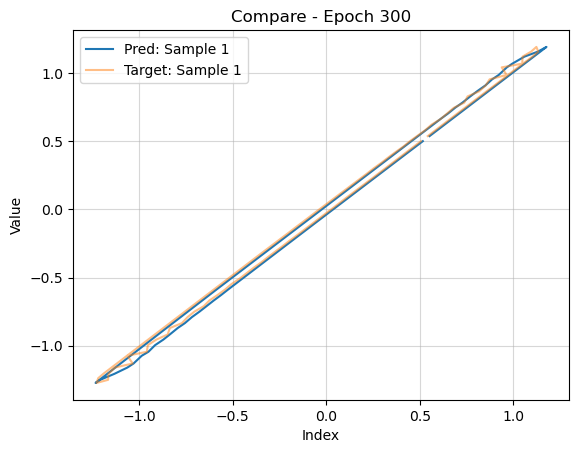

Epoch 301, Train Loss: 0.000734, Validation Loss: 0.000677
Epoch 302, Train Loss: 0.000714, Validation Loss: 0.000639
Epoch 303, Train Loss: 0.000672, Validation Loss: 0.000665
Epoch 304, Train Loss: 0.000688, Validation Loss: 0.000670
Epoch 305, Train Loss: 0.000679, Validation Loss: 0.000637
Saving model at epoch 305 with validation loss 0.000637...
Epoch 306, Train Loss: 0.000665, Validation Loss: 0.000644
Epoch 307, Train Loss: 0.000666, Validation Loss: 0.000637
Epoch 308, Train Loss: 0.000670, Validation Loss: 0.000663
Epoch 309, Train Loss: 0.000680, Validation Loss: 0.000704
Epoch 310, Train Loss: 0.000685, Validation Loss: 0.000634
Saving model at epoch 310 with validation loss 0.000634...
Epoch 311, Train Loss: 0.000666, Validation Loss: 0.000639
Epoch 312, Train Loss: 0.000667, Validation Loss: 0.000645
Epoch 313, Train Loss: 0.000691, Validation Loss: 0.000634
Epoch 314, Train Loss: 0.000666, Validation Loss: 0.000640
Epoch 315, Train Loss: 0.000710, Validation Loss: 0.0007

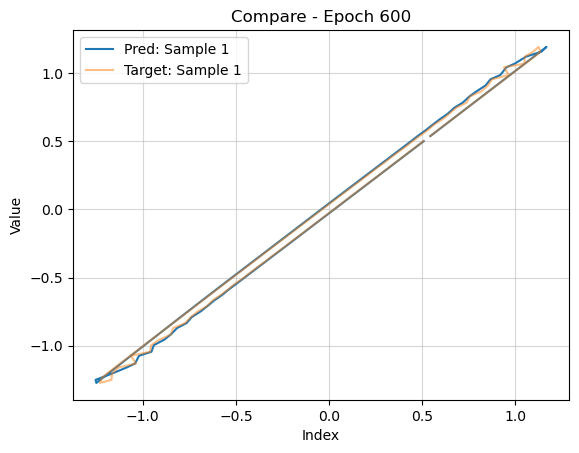

Epoch 601, Train Loss: 0.000551, Validation Loss: 0.000522
Epoch 602, Train Loss: 0.000528, Validation Loss: 0.000521
Epoch 603, Train Loss: 0.000530, Validation Loss: 0.000519
Saving model at epoch 603 with validation loss 0.000519...
Epoch 604, Train Loss: 0.000557, Validation Loss: 0.000565
Epoch 605, Train Loss: 0.000559, Validation Loss: 0.000566
Epoch 606, Train Loss: 0.000549, Validation Loss: 0.000545
Epoch 607, Train Loss: 0.000570, Validation Loss: 0.000536
Epoch 608, Train Loss: 0.000540, Validation Loss: 0.000560
Epoch 609, Train Loss: 0.000575, Validation Loss: 0.000669
Epoch 610, Train Loss: 0.000578, Validation Loss: 0.000536
Epoch 611, Train Loss: 0.000534, Validation Loss: 0.000516
Saving model at epoch 611 with validation loss 0.000516...
Epoch 612, Train Loss: 0.000537, Validation Loss: 0.000529
Epoch 613, Train Loss: 0.000532, Validation Loss: 0.000520
Epoch 614, Train Loss: 0.000546, Validation Loss: 0.000528
Epoch 615, Train Loss: 0.000533, Validation Loss: 0.0005

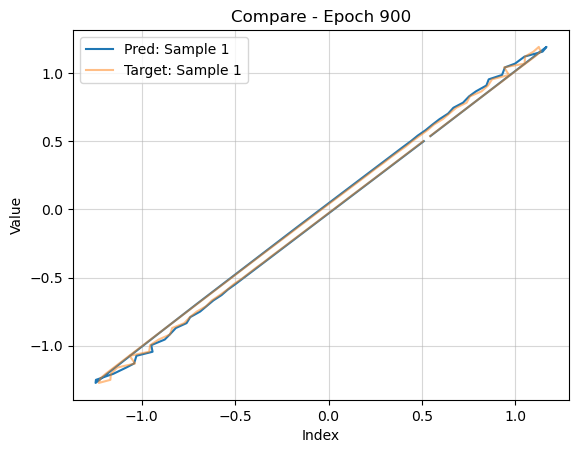

Epoch 901, Train Loss: 0.000471, Validation Loss: 0.000492
Epoch 902, Train Loss: 0.000491, Validation Loss: 0.000484
Epoch 903, Train Loss: 0.000482, Validation Loss: 0.000494
Epoch 904, Train Loss: 0.000474, Validation Loss: 0.000470
Epoch 905, Train Loss: 0.000470, Validation Loss: 0.000464
Saving model at epoch 905 with validation loss 0.000464...
Epoch 906, Train Loss: 0.000474, Validation Loss: 0.000474
Epoch 907, Train Loss: 0.000481, Validation Loss: 0.000473
Epoch 908, Train Loss: 0.000472, Validation Loss: 0.000472
Epoch 909, Train Loss: 0.000478, Validation Loss: 0.000465
Epoch 910, Train Loss: 0.000468, Validation Loss: 0.000469
Epoch 911, Train Loss: 0.000492, Validation Loss: 0.000548
Epoch 912, Train Loss: 0.000541, Validation Loss: 0.000467
Epoch 913, Train Loss: 0.000496, Validation Loss: 0.000464
Epoch 914, Train Loss: 0.000483, Validation Loss: 0.000466
Epoch 915, Train Loss: 0.000501, Validation Loss: 0.000475
Epoch 916, Train Loss: 0.000472, Validation Loss: 0.0004

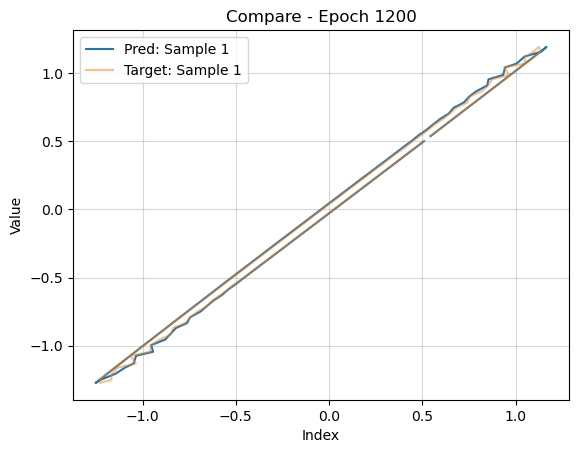

Epoch 1201, Train Loss: 0.000473, Validation Loss: 0.000429
Epoch 1202, Train Loss: 0.000439, Validation Loss: 0.000417
Saving model at epoch 1202 with validation loss 0.000417...
Epoch 1203, Train Loss: 0.000430, Validation Loss: 0.000422
Epoch 1204, Train Loss: 0.000421, Validation Loss: 0.000441
Epoch 1205, Train Loss: 0.000452, Validation Loss: 0.000463
Epoch 1206, Train Loss: 0.000435, Validation Loss: 0.000431
Epoch 1207, Train Loss: 0.000433, Validation Loss: 0.000422
Epoch 1208, Train Loss: 0.000429, Validation Loss: 0.000431
Epoch 1209, Train Loss: 0.000424, Validation Loss: 0.000417
Saving model at epoch 1209 with validation loss 0.000417...
Epoch 1210, Train Loss: 0.000422, Validation Loss: 0.000416
Saving model at epoch 1210 with validation loss 0.000416...
Epoch 1211, Train Loss: 0.000427, Validation Loss: 0.000419
Epoch 1212, Train Loss: 0.000421, Validation Loss: 0.000418
Epoch 1213, Train Loss: 0.000415, Validation Loss: 0.000426
Epoch 1214, Train Loss: 0.000450, Valida

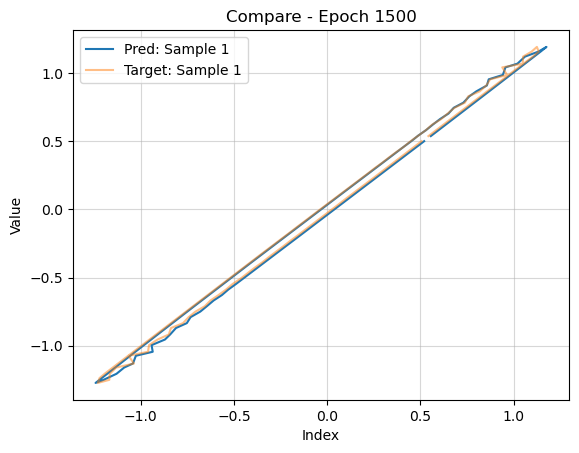

Epoch 1501, Train Loss: 0.000424, Validation Loss: 0.000409
Epoch 1502, Train Loss: 0.000405, Validation Loss: 0.000393
Epoch 1503, Train Loss: 0.000395, Validation Loss: 0.000395
Epoch 1504, Train Loss: 0.000419, Validation Loss: 0.000396
Epoch 1505, Train Loss: 0.000426, Validation Loss: 0.000497
Epoch 1506, Train Loss: 0.000464, Validation Loss: 0.000402
Epoch 1507, Train Loss: 0.000404, Validation Loss: 0.000404
Epoch 1508, Train Loss: 0.000403, Validation Loss: 0.000394
Epoch 1509, Train Loss: 0.000392, Validation Loss: 0.000393
Epoch 1510, Train Loss: 0.000410, Validation Loss: 0.000401
Epoch 1511, Train Loss: 0.000455, Validation Loss: 0.000404
Epoch 1512, Train Loss: 0.000395, Validation Loss: 0.000402
Epoch 1513, Train Loss: 0.000415, Validation Loss: 0.000392
Saving model at epoch 1513 with validation loss 0.000392...
Epoch 1514, Train Loss: 0.000394, Validation Loss: 0.000413
Epoch 1515, Train Loss: 0.000417, Validation Loss: 0.000398
Epoch 1516, Train Loss: 0.000411, Valida

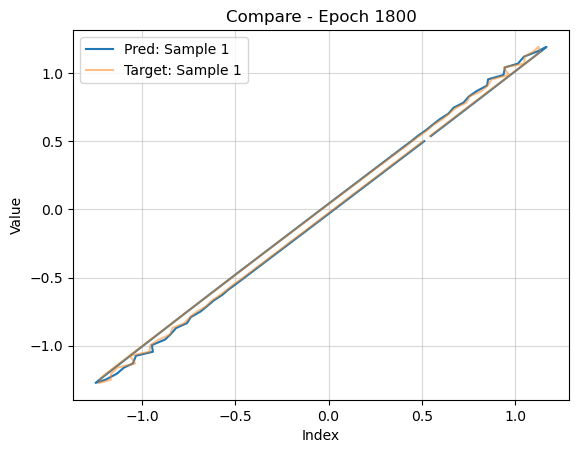

Epoch 1801, Train Loss: 0.000390, Validation Loss: 0.000379
Epoch 1802, Train Loss: 0.000380, Validation Loss: 0.000377
Epoch 1803, Train Loss: 0.000385, Validation Loss: 0.000389
Epoch 1804, Train Loss: 0.000394, Validation Loss: 0.000386
Epoch 1805, Train Loss: 0.000379, Validation Loss: 0.000389
Epoch 1806, Train Loss: 0.000391, Validation Loss: 0.000383
Epoch 1807, Train Loss: 0.000411, Validation Loss: 0.000427
Epoch 1808, Train Loss: 0.000424, Validation Loss: 0.000392
Epoch 1809, Train Loss: 0.000393, Validation Loss: 0.000394
Epoch 1810, Train Loss: 0.000386, Validation Loss: 0.000378
Epoch 1811, Train Loss: 0.000400, Validation Loss: 0.000384
Epoch 1812, Train Loss: 0.000387, Validation Loss: 0.000378
Epoch 1813, Train Loss: 0.000384, Validation Loss: 0.000391
Epoch 1814, Train Loss: 0.000389, Validation Loss: 0.000399
Epoch 1815, Train Loss: 0.000395, Validation Loss: 0.000392
Epoch 1816, Train Loss: 0.000377, Validation Loss: 0.000382
Epoch 1817, Train Loss: 0.000383, Valida

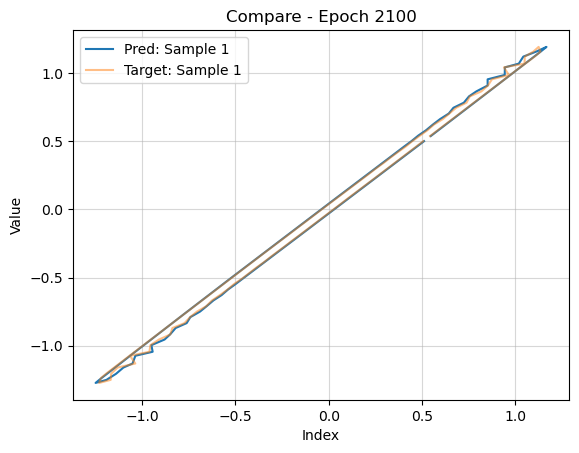

Epoch 2101, Train Loss: 0.000372, Validation Loss: 0.000366
Epoch 2102, Train Loss: 0.000360, Validation Loss: 0.000365
Epoch 2103, Train Loss: 0.000375, Validation Loss: 0.000420
Epoch 2104, Train Loss: 0.000377, Validation Loss: 0.000394
Epoch 2105, Train Loss: 0.000377, Validation Loss: 0.000398
Epoch 2106, Train Loss: 0.000384, Validation Loss: 0.000368
Epoch 2107, Train Loss: 0.000372, Validation Loss: 0.000387
Epoch 2108, Train Loss: 0.000374, Validation Loss: 0.000366
Epoch 2109, Train Loss: 0.000361, Validation Loss: 0.000372
Epoch 2110, Train Loss: 0.000381, Validation Loss: 0.000378
Epoch 2111, Train Loss: 0.000373, Validation Loss: 0.000369
Epoch 2112, Train Loss: 0.000360, Validation Loss: 0.000362
Saving model at epoch 2112 with validation loss 0.000362...
Epoch 2113, Train Loss: 0.000365, Validation Loss: 0.000367
Epoch 2114, Train Loss: 0.000376, Validation Loss: 0.000400
Epoch 2115, Train Loss: 0.000387, Validation Loss: 0.000369
Epoch 2116, Train Loss: 0.000363, Valida

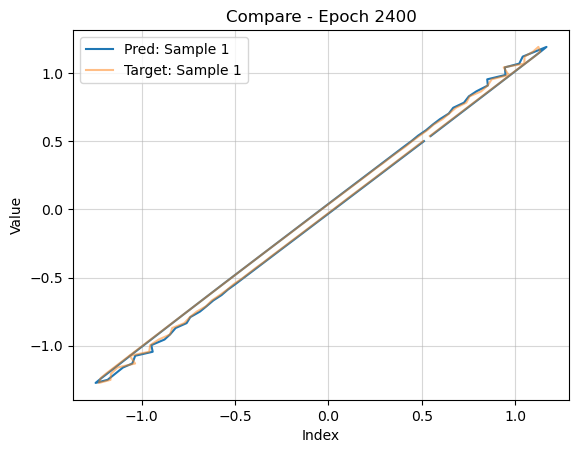

Saving model at epoch 2400 with validation loss 0.000348...
Epoch 2401, Train Loss: 0.000343, Validation Loss: 0.000347
Saving model at epoch 2401 with validation loss 0.000347...
Epoch 2402, Train Loss: 0.000343, Validation Loss: 0.000347
Saving model at epoch 2402 with validation loss 0.000347...
Epoch 2403, Train Loss: 0.000343, Validation Loss: 0.000348
Epoch 2404, Train Loss: 0.000346, Validation Loss: 0.000358
Epoch 2405, Train Loss: 0.000345, Validation Loss: 0.000348
Epoch 2406, Train Loss: 0.000348, Validation Loss: 0.000347
Saving model at epoch 2406 with validation loss 0.000347...
Epoch 2407, Train Loss: 0.000344, Validation Loss: 0.000353
Epoch 2408, Train Loss: 0.000351, Validation Loss: 0.000353
Epoch 2409, Train Loss: 0.000352, Validation Loss: 0.000381
Epoch 2410, Train Loss: 0.000368, Validation Loss: 0.000354
Epoch 2411, Train Loss: 0.000367, Validation Loss: 0.000392
Epoch 2412, Train Loss: 0.000360, Validation Loss: 0.000369
Epoch 2413, Train Loss: 0.000354, Valida

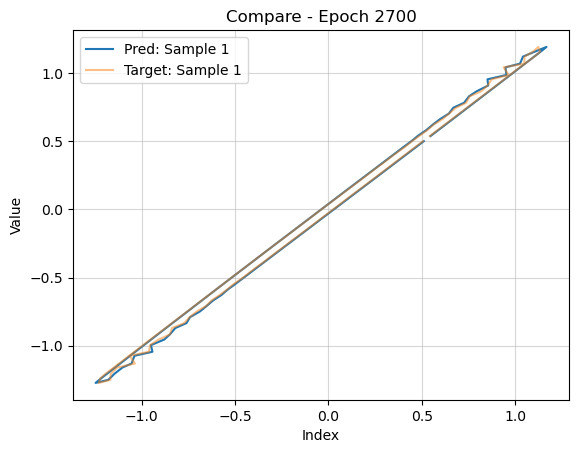

Epoch 2701, Train Loss: 0.000340, Validation Loss: 0.000326
Epoch 2702, Train Loss: 0.000347, Validation Loss: 0.000325
Epoch 2703, Train Loss: 0.000337, Validation Loss: 0.000334
Epoch 2704, Train Loss: 0.000333, Validation Loss: 0.000333
Epoch 2705, Train Loss: 0.000341, Validation Loss: 0.000346
Epoch 2706, Train Loss: 0.000327, Validation Loss: 0.000333
Epoch 2707, Train Loss: 0.000319, Validation Loss: 0.000322
Saving model at epoch 2707 with validation loss 0.000322...
Epoch 2708, Train Loss: 0.000328, Validation Loss: 0.000350
Epoch 2709, Train Loss: 0.000351, Validation Loss: 0.000327
Epoch 2710, Train Loss: 0.000328, Validation Loss: 0.000325
Epoch 2711, Train Loss: 0.000317, Validation Loss: 0.000323
Epoch 2712, Train Loss: 0.000324, Validation Loss: 0.000329
Epoch 2713, Train Loss: 0.000322, Validation Loss: 0.000330
Epoch 2714, Train Loss: 0.000326, Validation Loss: 0.000337
Epoch 2715, Train Loss: 0.000323, Validation Loss: 0.000328
Epoch 2716, Train Loss: 0.000334, Valida

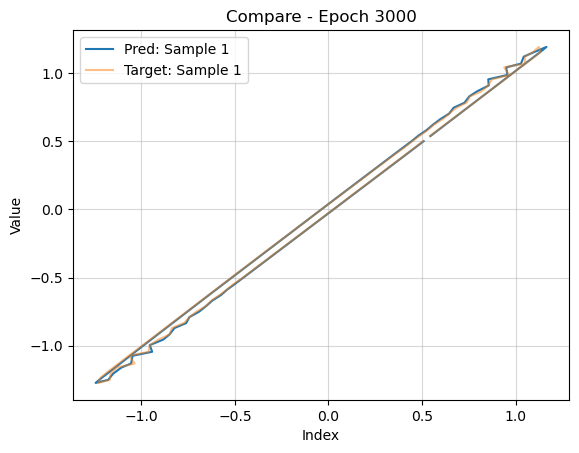

Saving model at epoch 3000 with validation loss 0.000301...
Training complete. Best model saved at ./Model/range/128/CH467160.pt.


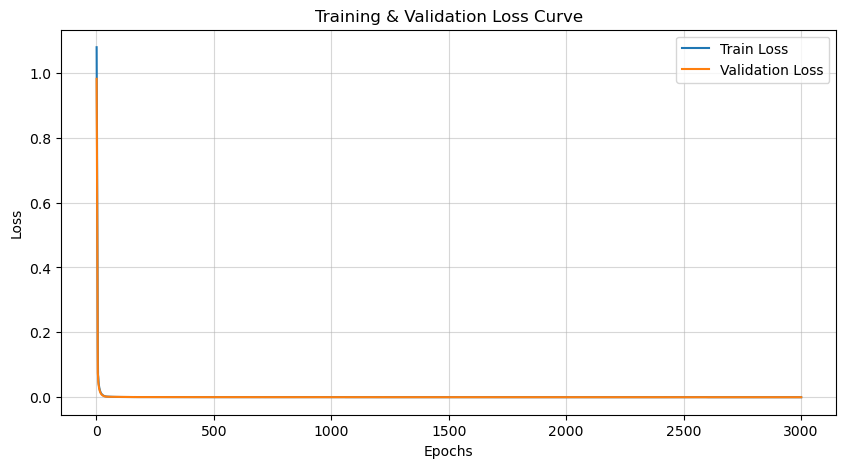

C:\Users\USER\AppData\Local\Temp\ipykernel_42872\3145885345.py:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))  # 載入最佳模

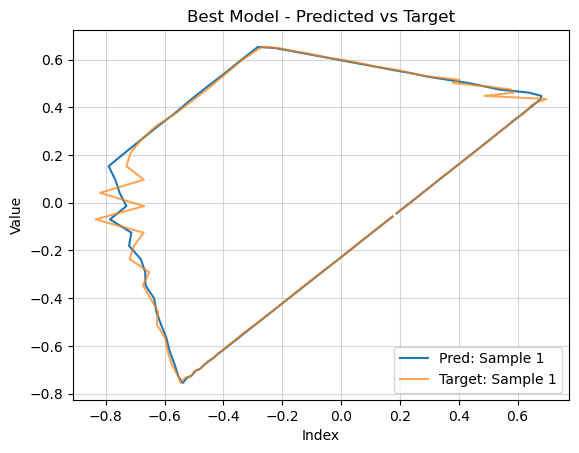

In [113]:
if __name__ == "__main__":

    data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N = load_dataset(
        material)

    train_loader, valid_loader, norm = get_dataloader(data_B, data_F, data_T,
                                                      data_H, data_N, data_Hdc,
                                                      data_Pcv)

    train_model(norm, train_loader, valid_loader)